## 1. create an image pyramid using pyramid_sampler

In [1]:
from dask.distributed import Client 
c = Client(n_workers=4, threads_per_worker=1)

In [2]:
c

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 31.18 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36429,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 31.18 GiB
Comm: tcp://127.0.0.1:42801,Total threads: 1
Dashboard: http://127.0.0.1:43437/status,Memory: 7.80 GiB
Nanny: tcp://127.0.0.1:40763,


### create the base image

In [3]:
import zarr
from pyramid_sampler import initialize_test_image

# create an on-disk zarr store
zarr_file = './zarr-test-image-pyramid.zarr'
zarr_store = zarr.group(zarr_file)

In [4]:
# write base level 0 image to the specified store and field name
new_field = "field1"
base_res = (1024, 1024, 1024)
chunks = (64, 64, 64)

In [5]:
initialize_test_image(zarr_store, new_field, base_res, chunks=chunks)

/home/chavlin/.pyenv/versions/3.11.7/envs/zarr_explorations/lib/python3.11/site-packages/distributed/client.py:3358: UserWarning: Sending large graph of size 10.57 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [6]:
lev0 = zarr_store['field1'][0]

In [7]:
lev0.info

Name,/field1/0
Type,zarr.core.Array
Data type,float64
Shape,"(1024, 1024, 1024)"
Chunk shape,"(64, 64, 64)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,8589934592 (8.0G)
No. bytes stored,7521005912 (7.0G)


### downsample the base image

In [8]:
from pyramid_sampler import Downsampler

refinement_factor = (2, 2, 2)
ds = Downsampler(zarr_file, refinement_factor, base_res, chunks)

In [9]:
field_to_downsample = "field1"
max_levels = 10
ds.downsample(max_levels, field_to_downsample)

pyramid_sampler : [INFO ] 2024-09-30 15:40:07,294:  downsampling to level 1.
pyramid_sampler : [INFO ] 2024-09-30 15:40:13,464:  downsampling to level 2.
pyramid_sampler : [INFO ] 2024-09-30 15:40:14,942:  downsampling to level 3.
pyramid_sampler : [INFO ] 2024-09-30 15:40:15,042:  downsampling to level 4.
pyramid_sampler : [INFO ] 2024-09-30 15:40:15,088:  cannot subdivide further, stopping downsampling at level 4.


## Loading the 3D image pyramid into yt

Using `load_amr_grids`, with a callable to read from the zarr... 

In [10]:
import numpy as np 
import yt 

# spatial extent of the whole domain
domain_le = np.array([0., 0., 0.])
domain_re = np.array([1., 1., 1.])

In [11]:
def _single_level_grids(yt_level, zarr_level, zarr_field):
    # for a single grid level, get all the grid extents 
    #
    # level : the current level number
    # zarr_field: the zarr field 
    #
    # returns a list of grid dictionaries 
    level_dims = np.asarray(zarr_field[zarr_level].shape).astype(int)
    grid_dims = np.asarray(zarr_field[zarr_level].chunks).astype(int)    
    n_grids_by_dim = level_dims // grid_dims  # number of grids in each dim     
    
    # spatial extent of a grid in each dim :
    grid_ds = (domain_re - domain_le) / n_grids_by_dim     
    
    grids = [] 
    for i_grid in range(zarr_field[zarr_level].nchunks):
        ijk_grid = np.unravel_index(i_grid, n_grids_by_dim, order='C')        
        le = domain_le + ijk_grid * grid_ds
        re = le + grid_ds
        grid_dict = {'left_edge': le, 
                     'right_edge': re, 
                     'dimensions': grid_dims, 
                     'level': yt_level, 
                     }                     
        grids.append(grid_dict)
    return grids

In [12]:
new_field='field1'
n_levels = len(list(zarr_store[new_field].array_keys()))
max_level = n_levels - 1
n_levels, max_level

(5, 4)

In [13]:
grids = [] 

# assemble from coarse to fine
for yt_level in range(n_levels):
    zarr_level = max_level - yt_level    
    
    grids_i = _single_level_grids(yt_level, zarr_level, zarr_store[new_field])
    grids.extend(grids_i)

    if yt_level == 0: 
        yt_level_0_dims = zarr_store[new_field][zarr_level].chunks
yt_level_0_dims    

(64, 64, 64)

In [14]:
len(grids)

4681

In [15]:
grids[0]

{'left_edge': array([0., 0., 0.]),
 'right_edge': array([1., 1., 1.]),
 'dimensions': array([64, 64, 64]),
 'level': 0}

In [16]:
def read_from_zarr(grid, field_tuple):
    field = field_tuple[1]
    si = grid.get_global_startindex()
    ei = si + grid.ActiveDimensions
    level = grid.Level # level 0 low res
    max_level = grid.index.max_level
    pyramid_level = max_level - level
    # print(pyramid_level)
    # print(si, ei)
    vals = zarr_store[field][pyramid_level][si[0]:ei[0],
                                            si[1]:ei[1],
                                            si[2]:ei[2]]
    return vals

In [17]:
for g in grids:    
    for field in zarr_store.group_keys():
        g[field] = (read_from_zarr, "")      

In [18]:
grids[0]

{'left_edge': array([0., 0., 0.]),
 'right_edge': array([1., 1., 1.]),
 'dimensions': array([64, 64, 64]),
 'level': 0,
 'field1': (<function __main__.read_from_zarr(grid, field_tuple)>, '')}

In [19]:
ds = yt.load_amr_grids(grids, yt_level_0_dims)

yt : [INFO     ] 2024-09-30 15:40:19,647 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-09-30 15:40:19,648 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2024-09-30 15:40:19,648 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-09-30 15:40:19,650 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-09-30 15:40:19,650 Parameters: cosmological_simulation   = 0


In [20]:
ds.field_list

[('stream', 'field1')]

yt : [INFO     ] 2024-09-30 15:40:20,538 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-09-30 15:40:20,539 ylim = 0.000000 1.000000
yt : [INFO     ] 2024-09-30 15:40:20,541 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-09-30 15:40:20,542 ylim = 0.000000 1.000000
yt : [INFO     ] 2024-09-30 15:40:20,546 Making a fixed resolution buffer of (('stream', 'field1')) 800 by 800



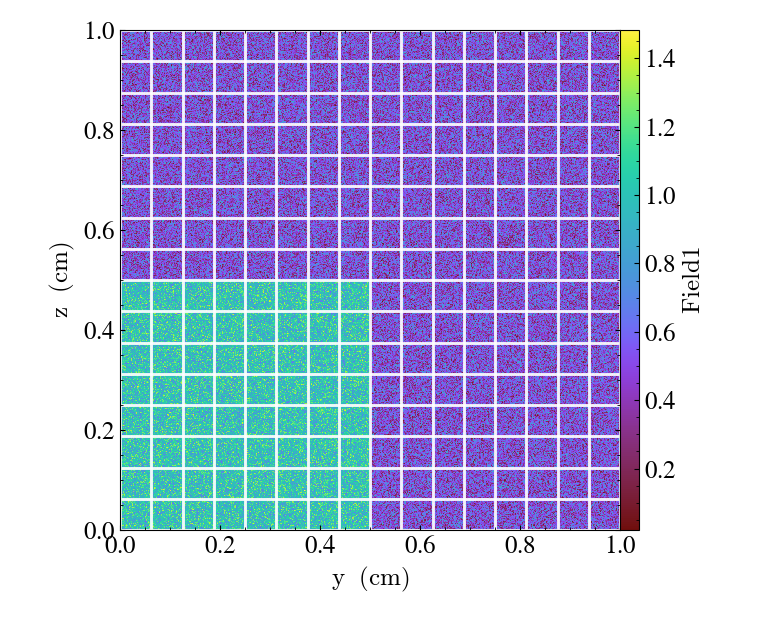

In [21]:
c = ds.domain_center.copy()
  
c[0] =  ds.domain_left_edge[0] + .25 * ds.domain_width[0]
slc = yt.SlicePlot(ds, 'x', ('stream', 'field1'), origin='native', center=c, window_size=(5,5))
slc.set_log(('stream', 'field1'), False)
slc.annotate_grids(edgecolors=(1,1,1),linewidth=2)
slc.show()

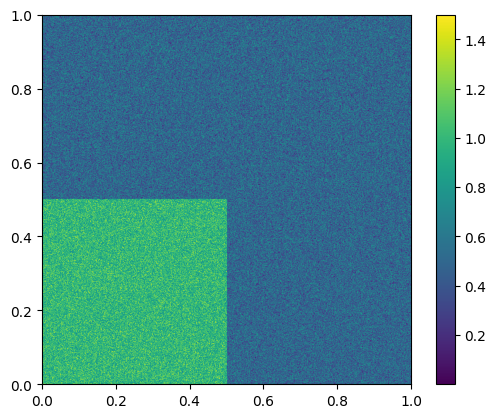

In [23]:
import matplotlib.pyplot as plt
f10 = zarr_store['field1'][0]
plt.imshow(f10[5, :, :], origin='lower', extent=(0,1,0,1))
plt.colorbar()